# Generate Synthetic Data

In [1]:
import ISOSIMpy.model as ism
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Generate Synthetic Observation Data

In [2]:
# make reproducible
np.random.seed(42)

### define input series
# define time steps
n_years = 50
timesteps = np.arange(0.0, n_years * 12.0, 1.0) # 50 years of monthly values

# this represents the tracer input to the aquifer
# we start with a constant input of 1.0
input_series = np.ones(len(timesteps))
# we add a pulse of higher tracer input during some years, similar to the
# increase in tritium in the atmosphere
# this is just a bell-shaped pulse
offset = 120.
scale = - 0.0004 # negative; closer to zero means wider pulse
input_series += np.exp(scale * ((timesteps - offset) ** 2))
# add some noise to the data
input_series += np.random.normal(0.0, 0.03, len(input_series))

In [3]:
### define model (the true system; in practice we don't know this)
# get decay constant
# we assume a half life of 12.3 years
t_half = 12.3 * 12.0
lambda_ = np.log(2.0) / t_half

# create true observations using the model
# time step is 1 month
m = ism.Model(
    dt=1.0,
    lambda_=lambda_,
    input_series=input_series,
    steady_state_input=1.,
    n_warmup_half_lives=10
)

# add an exponential-piston-flow unit
# define the true model parameters
epm_mtt_true = 12 * 40 # 40 years
epm_eta_true = 1.5
m.add_unit(
    ism.EPMUnit(mtt=epm_mtt_true, eta=epm_eta_true),
    fraction=.8, # 80 percent of the overall response
    prefix="epm"
)

# add a piston-flow unit
# define the true model parameters
pm_mtt_true = 12 * 5 # 5 years (faster than EPM)
m.add_unit(
    ism.PMUnit(mtt=pm_mtt_true),
    fraction=.2, # 20 percent of the overall response
    prefix="pm"
)

true_params = m.params

# simulate
output_series = m.simulate()

In [4]:
# make reproducible
np.random.seed(2025)

# define observations
# randomly select a number of observations from the output series
n_obs = 20
obs_idx = np.random.choice(len(timesteps), n_obs)
# select the corresponding timesteps and values
obs_timesteps = timesteps[obs_idx]
obs_values = output_series[obs_idx]
# add some noise to the observations (observation error)
obs_error = 0.01
obs_values += np.random.normal(0.0, obs_error, n_obs)

# make series we can later use in the model (has to be the same length as
# the input series, filled with NaN-values where we do not have any
# observations)
obs_series = np.full(len(input_series), np.nan)
obs_series[obs_idx] = obs_values

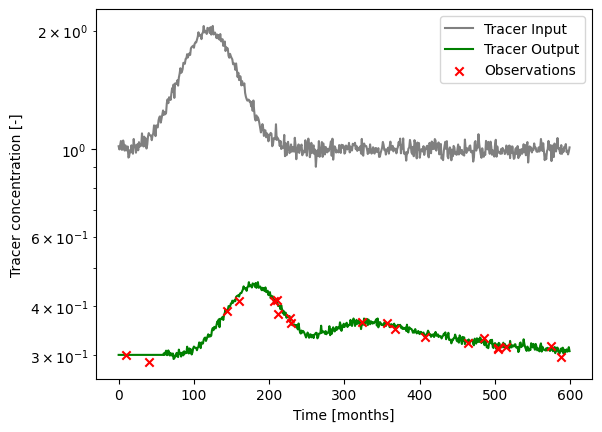

In [5]:
### plot input series, output series, and observations

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series,
    label="Tracer Input",
    c="grey"
)
# plot output series
ax.plot(
    timesteps,
    output_series,
    label="Tracer Output",
    c="green"
)
# plot observations
ax.scatter(
    obs_timesteps,
    obs_values,
    label="Observations",
    color="red",
    marker="x",
    zorder=10
)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.set_yscale("log")
ax.legend()
plt.show()

## 2. Store Values

In [6]:
# generate dummy monthly time stamps
start = "1960-01"

start_date = datetime.strptime(start, "%Y-%m")
out = []
for i in range(n_years * 12):
    # calculate year and month offset
    year = start_date.year + (start_date.month - 1 + i) // 12
    month = (start_date.month - 1 + i) % 12 + 1
    out.append(f"{year:04d}-{month:02d}")

timestamps= np.array(out, dtype=str)

In [7]:
# concatenate timestamps and input series
input_ = np.concatenate(
    (timestamps.reshape(-1, 1),
    input_series.reshape(-1, 1)),
    axis=1,
    dtype=object
)
# store input series as CSV
np.savetxt(
    "example_input_series.csv",
    input_,
    delimiter=",",
    header="Date, Value",
    fmt=["%s", "%1.3f"]
)

# concatenate timestamps and observation series
obs_ = np.concatenate(
    (timestamps.reshape(-1, 1),
    obs_series.reshape(-1, 1)),
    axis=1,
    dtype=object
)
# store observation series as CSV
np.savetxt(
    "example_observation_series.csv",
    obs_,
    delimiter=",",
    header="Date, Value",
    fmt=["%s", "%1.3f"]
)

# concatenate timestamps and full output series
output_ = np.concatenate(
    (timestamps.reshape(-1, 1),
    output_series.reshape(-1, 1)),
    axis=1,
    dtype=object
)
# store observation series as CSV
np.savetxt(
    "example_output_series.csv",
    output_,
    delimiter=",",
    header="Date, Value",
    fmt=["%s", "%1.3f"]
)